In [ ]:
import numpy as np
import cv2
import open3d as o3d
import threading
from ultralytics import YOLO
from queue import Queue
import time


fisheye_params = {
    "width": 2592,
    "height": 1944,
    "cx": 1296.0,
    "cy": 972.0,
    "radius": 952.56,
    "theta_max_rad": 1.5708
}

cam_settings = [
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": -18.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 54.0, "yaw": 48.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 28.0, "yaw": 150.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": 294.0},
]

views_path = [
    "recordings/camera_1.mp4",
    "recordings/camera_2.mp4",
    "recordings/camera_3.mp4",
    "recordings/camera_4.mp4"
]
fisheye_path = "recordings/fisheye.mp4"


model = YOLO("16_09_25_SENd_v2.5_10s_960.pt")
BEV = cv2.imread("ohlf.png")
homography_BEV = np.load("Homography for 229_camera_.npy")
homography_BEV_to_3D = np.load("Homography for bev to 3d.npy")


added_spheres = []
point_queue = Queue()
mesh = o3d.io.read_triangle_mesh("OHLF_obj/OHLF_v2.8.3 (1).obj", enable_post_processing=True)
mesh.compute_vertex_normals()
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="3D Model", width=1280, height=720)
vis.add_geometry(mesh)


def compute_basis(yaw_deg, pitch_deg):
    yaw_deg_corrected = yaw_deg - 90.0
    yaw, pitch = np.deg2rad([yaw_deg_corrected, pitch_deg])
    Rz = np.array([[np.cos(-yaw), -np.sin(-yaw), 0],
                   [np.sin(-yaw), np.cos(-yaw), 0],
                   [0, 0, 1]])
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(pitch), -np.sin(pitch)],
                   [0, np.sin(pitch), np.cos(pitch)]])
    return np.diag([1, -1, 1]) @ (Rx @ Rz)


def rect_to_fisheye_point(u, v, view_params, fisheye_params, rect_w, rect_h):
    Hr, Wr = rect_h, rect_w
    cx_r, cy_r = Wr / 2, Hr / 2
    fov = view_params["fov"]
    f = (Wr / 2) / np.tan(np.deg2rad(fov / 2))
    x = (u - cx_r) / f
    y = (v - cy_r) / f
    z = 1
    ray_rect = np.array([x, y, z])
    ray_rect /= np.linalg.norm(ray_rect)
    Rot = compute_basis(view_params["yaw"], view_params["pitch"])
    ray_fish = Rot.T @ ray_rect
    Xf, Yf, Zf = ray_fish
    theta = np.arccos(np.clip(Zf, -1, 1))
    phi = np.arctan2(Yf, Xf)
    radius, theta_max = fisheye_params["radius"], fisheye_params["theta_max_rad"]
    cx_f, cy_f = fisheye_params["cx"], fisheye_params["cy"]
    r = (theta / theta_max) * radius
    u_f = cx_f + r * np.cos(phi)
    v_f = cy_f - r * np.sin(phi)
    return (float(u_f), float(v_f))

def map_2d_to_3d(u, v, homography_bev_to_3d, y_value=0.0):
    src = np.array([u, v, 1.0], dtype=np.float64)
    dst = homography_bev_to_3d @ src
    dst /= dst[2]
    return np.array([dst[0], y_value, dst[1]])

def add_point_realtime(point3d):
    if added_spheres:
        vis.remove_geometry(added_spheres[-1], reset_bounding_box=False)
        added_spheres.clear()
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.25)
    sphere.paint_uniform_color([1, 0, 0])
    sphere.translate(point3d)
    vis.add_geometry(sphere, reset_bounding_box=False)
    vis.update_geometry(sphere)
    vis.poll_events()
    vis.update_renderer()
    added_spheres.append(sphere)

dis_rect_w, dis_rect_h = 2592, 2592
fov = 160.0
fov_RAD = np.deg2rad(fov)
focal = (dis_rect_w / 2) / np.tan(fov_RAD / 2)
dis_K_rect = np.array([[focal, 0.0, dis_rect_w / 2],
                       [0.0, focal, dis_rect_h / 2],
                       [0.0, 0.0, 1.0]])

f_fish = fisheye_params["radius"] / fisheye_params["theta_max_rad"]
K_fish = np.array([[f_fish, 0.0, fisheye_params["cx"]],
                   [0.0, f_fish, fisheye_params["cy"]],
                   [0.0, 0.0, 1.0]])
D_fish = np.zeros((4, 1))


TARGET_HEIGHT = 720
TARGET_WIDTH_FISHEYE = 720
TARGET_WIDTH_RECT = 720
cap_fish = cv2.VideoCapture(fisheye_path)
caps_rect = [cv2.VideoCapture(v) for v in views_path]

def read_frame_loop(cap):
    ret, frame = cap.read()
    if not ret:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, frame = cap.read()
    return ret, frame

def make_rect_grid_disp_from_native(views_native):
    h, w = views_native[0].shape[:2]
    grid = np.ones((h * 2, w * 2, 3), dtype=np.uint8) * 0 
    grid[0:h, 0:w] = views_native[0]
    grid[0:h, w:2*w] = views_native[1]
    grid[h:2*h, 0:w] = views_native[2]
    grid[h:2*h, w:2*w] = views_native[3]
    return grid


def run():
    global vis
    frame_index = 0 

    while True:
        ret_f, frame_fish = read_frame_loop(cap_fish)
        if not ret_f:
            break

        views = []
        for c in caps_rect:
            ret, f = read_frame_loop(c)
            if not ret:
                break
            views.append(f)
        if len(views) != 4:
            break

        frame_index += 1
        fisheye_h, fisheye_w = frame_fish.shape[:2]
        rect_h, rect_w = views[0].shape[:2]
        rect_grid_native = make_rect_grid_disp_from_native(views)
        all_points_this_cycle = []
        all_fisheye_points = []     
        all_rect_points_native = [] 
        for i, frame in enumerate(views):
            try:
                results = model(frame, verbose=False)
            except Exception as e:
                continue

            det_count = 0
            for result in results:
                if not hasattr(result, "boxes") or len(result.boxes) == 0:
                    continue

                for box in result.boxes:
                    cls = int(box.cls.cpu().numpy()) if hasattr(box.cls, "cpu") else int(box.cls)
                    if cls not in [0, 1, 2]:
                        continue

                    det_count += 1
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    u_full = int((x1 + x2) / 2.0) 
                    v_full = int(y2)            

                    pt_f = rect_to_fisheye_point(u_full, v_full, cam_settings[i], fisheye_params, rect_w, rect_h)
                    if pt_f is None:
                        continue
                    u_f, v_f = pt_f 

                    pt_f_arr = np.array([(u_f, v_f)], dtype=np.float32).reshape(-1, 1, 2)
                    try:
                        rect_point = cv2.fisheye.undistortPoints(pt_f_arr, K_fish, D_fish, P=dis_K_rect)
                        mapped_pt = cv2.perspectiveTransform(rect_point.astype(np.float32),
                                                             homography_BEV.astype(np.float32))
                        mx, my = int(mapped_pt[0][0][0]), int(mapped_pt[0][0][1])
                        p3d = map_2d_to_3d(mx, my, homography_BEV_to_3D)
                        p3d = [float(abs(float(x))) for x in p3d]
                    except Exception as e:
                        print(f"Transform error on view {i}: {e}")
                        continue

                    all_points_this_cycle.append(p3d)
                    all_fisheye_points.append((u_f, v_f))

                    tile_col = i % 2
                    tile_row = i // 2
                    x_in_grid = tile_col * rect_w + u_full
                    y_in_grid = tile_row * rect_h + v_full
                    all_rect_points_native.append((x_in_grid, y_in_grid))
                    print(f"VIEW {i+1} Class={cls} | Rect=({u_full},{v_full}) | Fish=({u_f:.1f},{v_f:.1f}) BEV=({mx},{my}) | 3D=({p3d[0]:.2f},{p3d[1]:.2f},{p3d[2]:.2f})")

            print(f"View {i+1}: {det_count} valid detections")


        for p3d in all_points_this_cycle:
            point_queue.put(p3d)

        fisheye_display_resized = cv2.resize(frame_fish, (TARGET_WIDTH_FISHEYE, TARGET_HEIGHT))
        rect_grid_resized = cv2.resize(rect_grid_native, (TARGET_WIDTH_RECT, TARGET_HEIGHT))

        scale_fish_x = TARGET_WIDTH_FISHEYE / float(fisheye_w)
        scale_fish_y = TARGET_HEIGHT / float(fisheye_h)
        scale_rect_x = TARGET_WIDTH_RECT / float(rect_grid_native.shape[1])
        scale_rect_y = TARGET_HEIGHT / float(rect_grid_native.shape[0])

        for (u_f, v_f) in all_fisheye_points:
            u_fd = int(u_f * scale_fish_x)
            v_fd = int(v_f * scale_fish_y)
            cv2.circle(fisheye_display_resized, (u_fd, v_fd), 6, (0, 0, 255), -1)

        for (x_nat, y_nat) in all_rect_points_native:
            u_rd = int(x_nat * scale_rect_x)
            v_rd = int(y_nat * scale_rect_y)
            cv2.circle(rect_grid_resized, (u_rd, v_rd), 6, (0, 255, 0), -1)
        canvas = np.ones((TARGET_HEIGHT, TARGET_WIDTH_FISHEYE + TARGET_WIDTH_RECT, 3), dtype=np.uint8) * 255
        canvas[:, 0:TARGET_WIDTH_FISHEYE] = fisheye_display_resized
        canvas[:, TARGET_WIDTH_FISHEYE:] = rect_grid_resized

        cv2.imshow("Unified Mapping", canvas)
        key = cv2.waitKey(1)
        if key == 27:
            break


    cap_fish.release()
    for c in caps_rect:
        c.release()
    cv2.destroyAllWindows()


cv_thread = threading.Thread(target=run, daemon=True)
cv_thread.start()

try:
    while cv_thread.is_alive():
        while not point_queue.empty():
            p = point_queue.get()
            add_point_realtime(p)
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.03)
finally:
    vis.destroy_window()
    cv2.destroyAllWindows()


View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections


C:\Users\Nahush\AppData\Local\Temp\ipykernel_9800\2839875142.py:179: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(box.cls.cpu().numpy()) if hasattr(box.cls, "cpu") else int(box.cls)


VIEW 4 Class=1 | Rect=(945,279) | Fish=(1252.1,1687.5) BEV=(1399,654) | 3D=(5.42,0.00,3.75)
View 4: 1 valid detections
View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 | Rect=(945,280) | Fish=(1251.9,1686.6) BEV=(1398,654) | 3D=(5.50,0.00,3.75)
View 4: 1 valid detections
View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 | Rect=(945,280) | Fish=(1251.9,1686.6) BEV=(1398,654) | 3D=(5.50,0.00,3.75)
View 4: 1 valid detections
View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 | Rect=(945,280) | Fish=(1251.9,1686.6) BEV=(1398,654) | 3D=(5.50,0.00,3.75)
View 4: 1 valid detections
View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 | Rect=(945,280) | Fish=(1251.9,1686.6) BEV=(1398,654) | 3D=(5.50,0.00,3.75)
View 4: 1 valid detections
View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections


In [ ]:
import numpy as np
import cv2
import open3d as o3d
import threading
from ultralytics import YOLO
from queue import Queue
import time


fisheye_params = {
    "width": 2592,
    "height": 1944,
    "cx": 1296.0,
    "cy": 972.0,
    "radius": 952.56,
    "theta_max_rad": 1.5708
}

cam_settings = [
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": -18.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 54.0, "yaw": 48.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 28.0, "yaw": 150.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": 294.0},
]

views_path = [
    "recordings/camera_1.mp4",
    "recordings/camera_2.mp4",
    "recordings/camera_3.mp4",
    "recordings/camera_4.mp4"
]
fisheye_path = "recordings/fisheye.mp4"

model = YOLO("16_09_25_SENd_v2.5_10s_960.pt")
BEV = cv2.imread("ohlf.png")
homography_BEV = np.load("Homography for 229_camera_.npy")
homography_BEV_to_3D = np.load("Homography for bev to 3d.npy")

added_spheres = []
point_queue = Queue()
mesh = o3d.io.read_triangle_mesh("OHLF_obj/OHLF_v2.8.3 (1).obj", enable_post_processing=True)
mesh.compute_vertex_normals()
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="3D Model", width=1280, height=720)
vis.add_geometry(mesh)


CLASS_COLORS = {
    0: (0, 255, 0),   
    1: (255, 0, 0),   
    2: (0, 165, 255),  
}
FONT = cv2.FONT_HERSHEY_SIMPLEX

def compute_basis(yaw_deg, pitch_deg):
    yaw_deg_corrected = yaw_deg - 90.0
    yaw, pitch = np.deg2rad([yaw_deg_corrected, pitch_deg])
    Rz = np.array([[np.cos(-yaw), -np.sin(-yaw), 0],
                   [np.sin(-yaw), np.cos(-yaw), 0],
                   [0, 0, 1]])
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(pitch), -np.sin(pitch)],
                   [0, np.sin(pitch), np.cos(pitch)]])
    return np.diag([1, -1, 1]) @ (Rx @ Rz)

def rect_to_fisheye_point(u, v, view_params, fisheye_params, rect_w, rect_h):
    Hr, Wr = rect_h, rect_w
    cx_r, cy_r = Wr / 2, Hr / 2
    fov = view_params["fov"]
    f = (Wr / 2) / np.tan(np.deg2rad(fov / 2))
    x = (u - cx_r) / f
    y = (v - cy_r) / f
    z = 1
    ray_rect = np.array([x, y, z])
    ray_rect /= np.linalg.norm(ray_rect)
    Rot = compute_basis(view_params["yaw"], view_params["pitch"])
    ray_fish = Rot.T @ ray_rect
    Xf, Yf, Zf = ray_fish
    theta = np.arccos(np.clip(Zf, -1, 1))
    phi = np.arctan2(Yf, Xf)
    radius, theta_max = fisheye_params["radius"], fisheye_params["theta_max_rad"]
    cx_f, cy_f = fisheye_params["cx"], fisheye_params["cy"]
    r = (theta / theta_max) * radius
    u_f = cx_f + r * np.cos(phi)
    v_f = cy_f - r * np.sin(phi)
    return (float(u_f), float(v_f))

def map_2d_to_3d(u, v, homography_bev_to_3d, y_value=0.0):
    src = np.array([u, v, 1.0], dtype=np.float64)
    dst = homography_bev_to_3d @ src
    dst /= dst[2]
    return np.array([dst[0], y_value, dst[1]])

def add_point_realtime(point3d):
    if added_spheres:
        vis.remove_geometry(added_spheres[-1], reset_bounding_box=False)
        added_spheres.clear()
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.25)
    sphere.paint_uniform_color([1, 0, 0])
    sphere.translate(point3d)
    vis.add_geometry(sphere, reset_bounding_box=False)
    vis.update_geometry(sphere)
    vis.poll_events()
    vis.update_renderer()
    added_spheres.append(sphere)

dis_rect_w, dis_rect_h = 2592, 2592
fov = 160.0
fov_RAD = np.deg2rad(fov)
focal = (dis_rect_w / 2) / np.tan(fov_RAD / 2)
dis_K_rect = np.array([[focal, 0.0, dis_rect_w / 2],
                       [0.0, focal, dis_rect_h / 2],
                       [0.0, 0.0, 1.0]])

f_fish = fisheye_params["radius"] / fisheye_params["theta_max_rad"]
K_fish = np.array([[f_fish, 0.0, fisheye_params["cx"]],
                   [0.0, f_fish, fisheye_params["cy"]],
                   [0.0, 0.0, 1.0]])
D_fish = np.zeros((4, 1))

TARGET_HEIGHT = 720
TARGET_WIDTH_FISHEYE = 720
TARGET_WIDTH_RECT = 720
cap_fish = cv2.VideoCapture(fisheye_path)
caps_rect = [cv2.VideoCapture(v) for v in views_path]

def read_frame_loop(cap):
    ret, frame = cap.read()
    if not ret:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, frame = cap.read()
    return ret, frame

def make_rect_grid_disp_from_native(views_native):
    h, w = views_native[0].shape[:2]
    grid = np.ones((h * 2, w * 2, 3), dtype=np.uint8) * 0 
    grid[0:h, 0:w] = views_native[0]
    grid[0:h, w:2*w] = views_native[1]
    grid[h:2*h, 0:w] = views_native[2]
    grid[h:2*h, w:2*w] = views_native[3]
    return grid

def run():
    global vis
    frame_index = 0 

    while True:
        ret_f, frame_fish = read_frame_loop(cap_fish)
        if not ret_f:
            break

        views = []
        for c in caps_rect:
            ret, f = read_frame_loop(c)
            if not ret:
                break

            views.append(f.copy())
        if len(views) != 4:
            break

        frame_index += 1
        fisheye_h, fisheye_w = frame_fish.shape[:2]
        rect_h, rect_w = views[0].shape[:2]
        all_points_this_cycle = []
        all_fisheye_points = []     
        all_rect_points_native = [] 

        for i, frame in enumerate(views):
            try:
                results = model(frame, verbose=False)
            except Exception as e:
                print("Model error:", e)
                continue

            det_count = 0
            for result in results:
                if not hasattr(result, "boxes") or len(result.boxes) == 0:
                    continue

                for box in result.boxes:
                    try:
                        cls = int(box.cls.cpu().numpy()) if hasattr(box.cls, "cpu") else int(box.cls)
                    except Exception:
                        cls = int(getattr(box, "class", -1))

                    if cls not in [0, 1, 2]:
                        continue

                    try:
                        conf = float(box.conf.cpu().numpy()) if hasattr(box.conf, "cpu") else float(box.conf)
                    except Exception:
                        conf = 0.0

                    try:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    except Exception:
                        coords = np.array(box.xyxy).reshape(-1)
                        x1, y1, x2, y2 = coords[0], coords[1], coords[2], coords[3]

                    color = CLASS_COLORS.get(cls, (0, 255, 255))
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)


                    det_count += 1
                    u_full = int((x1 + x2) / 2.0)
                    v_full = int(y2*0.9)

                    pt_f = rect_to_fisheye_point(u_full, v_full, cam_settings[i], fisheye_params, rect_w, rect_h)
                    if pt_f is None:
                        continue
                    u_f, v_f = pt_f 

                    pt_f_arr = np.array([(u_f, v_f)], dtype=np.float32).reshape(-1, 1, 2)
                    try:
                        rect_point = cv2.fisheye.undistortPoints(pt_f_arr, K_fish, D_fish, P=dis_K_rect)
                        mapped_pt = cv2.perspectiveTransform(rect_point,homography_BEV)
                        mx, my = int(mapped_pt[0][0][0]), int(mapped_pt[0][0][1])
                        p3d = map_2d_to_3d(mx, my, homography_BEV_to_3D)
                        p3d = [float(abs(float(x))) for x in p3d]
                    except Exception as e:
                        print(f"Transform error on view {i}: {e}")
                        continue

                    all_points_this_cycle.append(p3d)
                    all_fisheye_points.append((u_f, v_f))

                    tile_col = i % 2
                    tile_row = i // 2
                    x_in_grid = tile_col * rect_w + u_full
                    y_in_grid = tile_row * rect_h + v_full
                    all_rect_points_native.append((x_in_grid, y_in_grid))
                    print(f"VIEW {i+1} Class={cls} Conf={conf:.2f} | Rect=({u_full},{v_full}) | Fish=({u_f:.1f},{v_f:.1f}) | BEV=({mx},{my}) | 3D=({p3d[0]:.2f},{p3d[1]:.2f},{p3d[2]:.2f})")

            print(f"View {i+1}: {det_count} valid detections")

 
        for p3d in all_points_this_cycle:
            point_queue.put(p3d)

        rect_grid_native = make_rect_grid_disp_from_native(views)
        fisheye_display_resized = cv2.resize(frame_fish, (TARGET_WIDTH_FISHEYE, TARGET_HEIGHT))
        rect_grid_resized = cv2.resize(rect_grid_native, (TARGET_WIDTH_RECT, TARGET_HEIGHT))

        scale_fish_x = TARGET_WIDTH_FISHEYE / float(fisheye_w)
        scale_fish_y = TARGET_HEIGHT / float(fisheye_h)
        scale_rect_x = TARGET_WIDTH_RECT / float(rect_grid_native.shape[1])
        scale_rect_y = TARGET_HEIGHT / float(rect_grid_native.shape[0])

        for (u_f, v_f) in all_fisheye_points:
            u_fd = int(u_f * scale_fish_x)
            v_fd = int(v_f * scale_fish_y)
            cv2.circle(fisheye_display_resized, (u_fd, v_fd), 6, (0, 0, 255), -1)

        for (x_nat, y_nat) in all_rect_points_native:
            u_rd = int(x_nat * scale_rect_x)
            v_rd = int(y_nat * scale_rect_y)
            cv2.circle(rect_grid_resized, (u_rd, v_rd), 6, (0, 255, 0), -1)

        canvas = np.ones((TARGET_HEIGHT, TARGET_WIDTH_FISHEYE + TARGET_WIDTH_RECT, 3), dtype=np.uint8) 
        canvas[:, 0:TARGET_WIDTH_FISHEYE] = fisheye_display_resized
        canvas[:, TARGET_WIDTH_FISHEYE:] = rect_grid_resized

        cv2.imshow("Unified Mapping", canvas)
        key = cv2.waitKey(1)
        if key == 27:
            break

    cap_fish.release()
    for c in caps_rect:
        c.release()
    cv2.destroyAllWindows()

cv_thread = threading.Thread(target=run, daemon=True)
cv_thread.start()

try:
    while cv_thread.is_alive():
        while not point_queue.empty():
            p = point_queue.get()
            add_point_realtime(p)
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.03)
finally:
    vis.destroy_window()
    cv2.destroyAllWindows()


View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections


C:\Users\Nahush\AppData\Local\Temp\ipykernel_9800\120850724.py:183: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(box.cls.cpu().numpy()) if hasattr(box.cls, "cpu") else int(box.cls)
C:\Users\Nahush\AppData\Local\Temp\ipykernel_9800\120850724.py:191: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(box.conf.cpu().numpy()) if hasattr(box.conf, "cpu") else float(box.conf)


VIEW 4 Class=1 Conf=0.98 | Rect=(945,251) | Fish=(1258.2,1710.7) | BEV=(1409,646) | 3D=(4.66,0.00,4.17)
View 4: 1 valid detections
View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 Conf=0.98 | Rect=(945,252) | Fish=(1258.0,1709.8) | BEV=(1409,646) | 3D=(4.66,0.00,4.17)
View 4: 1 valid detections
View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 Conf=0.98 | Rect=(945,252) | Fish=(1258.0,1709.8) | BEV=(1409,646) | 3D=(4.66,0.00,4.17)
View 4: 1 valid detections
View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 Conf=0.98 | Rect=(945,252) | Fish=(1258.0,1709.8) | BEV=(1409,646) | 3D=(4.66,0.00,4.17)
View 4: 1 valid detections
View 1: 0 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 Conf=0.98 | Rect=(945,252) | Fish=(1258.0,1709.8) | BEV=(1409,646) | 3D=(4.66,0.00,4.17)
View 4: 1 valid detections
View 1: 0 valid detec

In [1]:
import numpy as np
import cv2
import open3d as o3d
import threading
from ultralytics import YOLO
from queue import Queue
import time
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


fisheye_params = {
    "width": 2592,
    "height": 1944,
    "cx": 1296.0,
    "cy": 972.0,
    "radius": 952.56,
    "theta_max_rad": 1.5708
}

cam_settings = [
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": -18.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 54.0, "yaw": 48.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 28.0, "yaw": 150.0},
    {"cx": 1296.0, "cy": 972.0, "fov": 90.0, "pitch": 58.0, "yaw": 294.0},
]

views_path = [
    "recordings_2/camera_1.mp4",
    "recordings_2/camera_2.mp4",
    "recordings_2/camera_3.mp4",
    "recordings_2/camera_4.mp4"
]
fisheye_path = "recordings_2/fisheye.mp4"

model = YOLO("16_09_25_SENd_v2.5_10s_960.pt").to(device)
BEV = cv2.imread("ohlf.png")
homography_BEV = np.load("Homography for 229_camera_.npy")
homography_BEV_to_3D = np.load("Homography for bev to 3d.npy")

added_spheres = []
point_queue = Queue()
mesh = o3d.io.read_triangle_mesh("OHLF_obj/OHLF_v2.8.3 (1).obj", enable_post_processing=True)
mesh.compute_vertex_normals()
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="3D Model", width=1280, height=720)
vis.add_geometry(mesh)


CLASS_COLORS = {
    0: (0, 255, 0),   
    1: (255, 0, 0),   
    2: (0, 165, 255),  
}
FONT = cv2.FONT_HERSHEY_SIMPLEX

def compute_basis(yaw_deg, pitch_deg):
    yaw_deg_corrected = yaw_deg - 90.0
    yaw, pitch = np.deg2rad([yaw_deg_corrected, pitch_deg])
    Rz = np.array([[np.cos(-yaw), -np.sin(-yaw), 0],
                   [np.sin(-yaw), np.cos(-yaw), 0],
                   [0, 0, 1]])
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(pitch), -np.sin(pitch)],
                   [0, np.sin(pitch), np.cos(pitch)]])
    return np.diag([1, -1, 1]) @ (Rx @ Rz)

def rect_to_fisheye_point(u, v, view_params, fisheye_params, rect_w, rect_h):
    Hr, Wr = rect_h, rect_w
    cx_r, cy_r = Wr / 2, Hr / 2
    fov = view_params["fov"]
    f = (Wr / 2) / np.tan(np.deg2rad(fov / 2))
    x = (u - cx_r) / f
    y = (v - cy_r) / f
    z = 1
    ray_rect = np.array([x, y, z])
    ray_rect /= np.linalg.norm(ray_rect)
    Rot = compute_basis(view_params["yaw"], view_params["pitch"])
    ray_fish = Rot.T @ ray_rect
    Xf, Yf, Zf = ray_fish
    theta = np.arccos(np.clip(Zf, -1, 1))
    phi = np.arctan2(Yf, Xf)
    radius, theta_max = fisheye_params["radius"], fisheye_params["theta_max_rad"]
    cx_f, cy_f = fisheye_params["cx"], fisheye_params["cy"]
    r = (theta / theta_max) * radius
    u_f = cx_f + r * np.cos(phi)
    v_f = cy_f - r * np.sin(phi)
    return (float(u_f), float(v_f))

def map_2d_to_3d(u, v, homography_bev_to_3d, y_value=0.0):
    src = np.array([u, v, 1.0], dtype=np.float64)
    dst = homography_bev_to_3d @ src
    dst /= dst[2]
    return np.array([dst[0], y_value, dst[1]])

def add_point_realtime(point3d):
    if added_spheres:
        vis.remove_geometry(added_spheres[-1], reset_bounding_box=False)
        added_spheres.clear()
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.25)
    sphere.paint_uniform_color([1, 0, 0])
    sphere.translate(point3d)
    vis.add_geometry(sphere, reset_bounding_box=False)
    vis.update_geometry(sphere)
    vis.poll_events()
    vis.update_renderer()
    added_spheres.append(sphere)

dis_rect_w, dis_rect_h = 2592, 2592
fov = 160.0
fov_RAD = np.deg2rad(fov)
focal = (dis_rect_w / 2) / np.tan(fov_RAD / 2)
dis_K_rect = np.array([[focal, 0.0, dis_rect_w / 2],
                       [0.0, focal, dis_rect_h / 2],
                       [0.0, 0.0, 1.0]])

f_fish = fisheye_params["radius"] / fisheye_params["theta_max_rad"]
K_fish = np.array([[f_fish, 0.0, fisheye_params["cx"]],
                   [0.0, f_fish, fisheye_params["cy"]],
                   [0.0, 0.0, 1.0]])
D_fish = np.zeros((4, 1))

TARGET_HEIGHT = 720
TARGET_WIDTH_FISHEYE = 720
TARGET_WIDTH_RECT = 720
cap_fish = cv2.VideoCapture(fisheye_path)
caps_rect = [cv2.VideoCapture(v) for v in views_path]

def read_frame_loop(cap):
    ret, frame = cap.read()
    if not ret:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, frame = cap.read()
    return ret, frame

def make_rect_grid_disp_from_native(views_native):
    h, w = views_native[0].shape[:2]
    grid = np.ones((h * 2, w * 2, 3), dtype=np.uint8) * 0 
    grid[0:h, 0:w] = views_native[0]
    grid[0:h, w:2*w] = views_native[1]
    grid[h:2*h, 0:w] = views_native[2]
    grid[h:2*h, w:2*w] = views_native[3]
    return grid

def run():
    global vis
    frame_index = 0 

    while True:
        ret_f, frame_fish = read_frame_loop(cap_fish)
        if not ret_f:
            break

        views = []
        for c in caps_rect:
            ret, f = read_frame_loop(c)
            if not ret:
                break

            views.append(f.copy())
        if len(views) != 4:
            break

        frame_index += 1
        fisheye_h, fisheye_w = frame_fish.shape[:2]
        rect_h, rect_w = views[0].shape[:2]
        all_points_this_cycle = []
        all_fisheye_points = []     
        all_rect_points_native = [] 

        for i, frame in enumerate(views):
            try:
                results = model(frame, device=device, verbose=False)
            except Exception as e:
                print("Model error:", e)
                continue

            det_count = 0
            for result in results:
                if not hasattr(result, "boxes") or len(result.boxes) == 0:
                    continue

                for box in result.boxes:
                    try:
                        cls = int(box.cls.cpu().numpy()) if hasattr(box.cls, "cpu") else int(box.cls)
                    except Exception:
                        cls = int(getattr(box, "class", -1))

                    if cls not in [0, 1, 2]:
                        continue

                    try:
                        conf = float(box.conf.cpu().numpy()) if hasattr(box.conf, "cpu") else float(box.conf)
                    except Exception:
                        conf = 0.0

                    try:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    except Exception:
                        coords = np.array(box.xyxy).reshape(-1)
                        x1, y1, x2, y2 = coords[0], coords[1], coords[2], coords[3]

                    color = CLASS_COLORS.get(cls, (0, 255, 255))
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)


                    det_count += 1
                    u_full = int((x1 + x2) / 2.0)
                    v_full = int(y2)

                    pt_f = rect_to_fisheye_point(u_full, v_full, cam_settings[i], fisheye_params, rect_w, rect_h)
                    if pt_f is None:
                        continue
                    u_f, v_f = pt_f 

                    pt_f_arr = np.array([(u_f, v_f)], dtype=np.float32).reshape(-1, 1, 2)
                    try:
                        rect_point = cv2.fisheye.undistortPoints(pt_f_arr, K_fish, D_fish, P=dis_K_rect)
                        mapped_pt = cv2.perspectiveTransform(rect_point,homography_BEV)
                        mx, my = int(mapped_pt[0][0][0]), int(mapped_pt[0][0][1])
                        p3d = map_2d_to_3d(mx, my, homography_BEV_to_3D)
                        p3d = [float(abs(float(x))) for x in p3d]
                    except Exception as e:
                        print(f"Transform error on view {i}: {e}")
                        continue

                    all_points_this_cycle.append(p3d)
                    all_fisheye_points.append((u_f, v_f))

                    tile_col = i % 2
                    tile_row = i // 2
                    x_in_grid = tile_col * rect_w + u_full
                    y_in_grid = tile_row * rect_h + v_full
                    all_rect_points_native.append((x_in_grid, y_in_grid))
                    print(f"VIEW {i+1} Class={cls} Conf={conf:.2f} | Rect=({u_full},{v_full}) | Fish=({u_f:.1f},{v_f:.1f}) | BEV=({mx},{my}) | 3D=({p3d[0]:.2f},{p3d[1]:.2f},{p3d[2]:.2f})")

            print(f"View {i+1}: {det_count} valid detections")

 
        for p3d in all_points_this_cycle:
            point_queue.put(p3d)

        rect_grid_native = make_rect_grid_disp_from_native(views)
        fisheye_display_resized = cv2.resize(frame_fish, (TARGET_WIDTH_FISHEYE, TARGET_HEIGHT))
        rect_grid_resized = cv2.resize(rect_grid_native, (TARGET_WIDTH_RECT, TARGET_HEIGHT))

        scale_fish_x = TARGET_WIDTH_FISHEYE / float(fisheye_w)
        scale_fish_y = TARGET_HEIGHT / float(fisheye_h)
        scale_rect_x = TARGET_WIDTH_RECT / float(rect_grid_native.shape[1])
        scale_rect_y = TARGET_HEIGHT / float(rect_grid_native.shape[0])

        for (u_f, v_f) in all_fisheye_points:
            u_fd = int(u_f * scale_fish_x)
            v_fd = int(v_f * scale_fish_y)
            cv2.circle(fisheye_display_resized, (u_fd, v_fd), 6, (0, 0, 255), -1)

        for (x_nat, y_nat) in all_rect_points_native:
            u_rd = int(x_nat * scale_rect_x)
            v_rd = int(y_nat * scale_rect_y)
            cv2.circle(rect_grid_resized, (u_rd, v_rd), 6, (0, 255, 0), -1)

        canvas = np.ones((TARGET_HEIGHT, TARGET_WIDTH_FISHEYE + TARGET_WIDTH_RECT, 3), dtype=np.uint8) 
        canvas[:, 0:TARGET_WIDTH_FISHEYE] = fisheye_display_resized
        canvas[:, TARGET_WIDTH_FISHEYE:] = rect_grid_resized

        cv2.imshow("Unified Mapping", canvas)
        key = cv2.waitKey(1)
        if key == 27:
            break

    cap_fish.release()
    for c in caps_rect:
        c.release()
    cv2.destroyAllWindows()

cv_thread = threading.Thread(target=run, daemon=True)
cv_thread.start()

try:
    while cv_thread.is_alive():
        while not point_queue.empty():
            p = point_queue.get()
            add_point_realtime(p)
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.03)
finally:
    vis.destroy_window()
    cv2.destroyAllWindows()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device: cuda


C:\Users\Nahush\AppData\Local\Temp\ipykernel_1496\640523015.py:187: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(box.cls.cpu().numpy()) if hasattr(box.cls, "cpu") else int(box.cls)
C:\Users\Nahush\AppData\Local\Temp\ipykernel_1496\640523015.py:195: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(box.conf.cpu().numpy()) if hasattr(box.conf, "cpu") else float(box.conf)


VIEW 1 Class=1 Conf=0.98 | Rect=(845,504) | Fish=(1673.9,1309.0) | BEV=(1314,648) | 3D=(11.86,0.00,4.08)
View 1: 1 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 Conf=0.98 | Rect=(323,585) | Fish=(1711.3,1204.0) | BEV=(1302,652) | 3D=(12.75,0.00,3.88)
VIEW 4 Class=0 Conf=0.95 | Rect=(964,214) | Fish=(1247.7,1742.0) | BEV=(1429,636) | 3D=(3.13,0.00,4.69)
View 4: 2 valid detections
VIEW 1 Class=1 Conf=0.98 | Rect=(845,505) | Fish=(1673.2,1308.6) | BEV=(1314,648) | 3D=(11.86,0.00,4.08)
View 1: 1 valid detections
View 2: 0 valid detections
View 3: 0 valid detections
VIEW 4 Class=1 Conf=0.98 | Rect=(323,585) | Fish=(1711.3,1204.0) | BEV=(1302,652) | 3D=(12.75,0.00,3.88)
VIEW 4 Class=0 Conf=0.95 | Rect=(958,214) | Fish=(1253.7,1741.7) | BEV=(1429,635) | 3D=(3.13,0.00,4.74)
View 4: 2 valid detections
VIEW 1 Class=1 Conf=0.98 | Rect=(845,505) | Fish=(1673.2,1308.6) | BEV=(1314,648) | 3D=(11.86,0.00,4.08)
View 1: 1 valid detections
View 2: 0 valid detectio

In [8]:
import numpy as np
from sklearn.cluster import DBSCAN

points = np.array([
    [10.0, 10.1],
    [10.2, 10.0],
    [10.3, 10.0],
    [10.1, 10.8],
    [10.3, 10.9]
])
labels = np.array([1, 0, 0, 1, 1])  

unique_classes = np.unique(labels)
cluster_results = {}

for cls in unique_classes:
    cls_points = points[labels == cls]
    db = DBSCAN(eps=0.5, min_samples=2).fit(cls_points)
    cluster_results[cls] = db.labels_

    print(f"Class {cls}: cluster labels -> {db.labels_}")


Class 0: cluster labels -> [0 0]
Class 1: cluster labels -> [-1  0  0]


In [20]:
import numpy as np
from sklearn.cluster import DBSCAN

points = np.array([
    (1622, 1272),
    (1629, 1227),
    (1645, 1160),
    (1652, 1120)
], dtype=float)

# Choose an eps bigger than the spacing (~50)
eps = 50
min_samples = 1

db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
labels = db.labels_

print("Labels:", labels)

# Group clusters
unique_clusters = np.unique(labels)

for cluster_id in unique_clusters:
    cluster_points = points[labels == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(cluster_points)
    
    # Compute centroid
    centroid = cluster_points.mean(axis=0)
    print("Centroid:", centroid)


Labels: [0 0 1 1]

Cluster 0:
[[1622. 1272.]
 [1629. 1227.]]
Centroid: [1625.5 1249.5]

Cluster 1:
[[1645. 1160.]
 [1652. 1120.]]
Centroid: [1648.5 1140. ]


In [1]:
import cv2

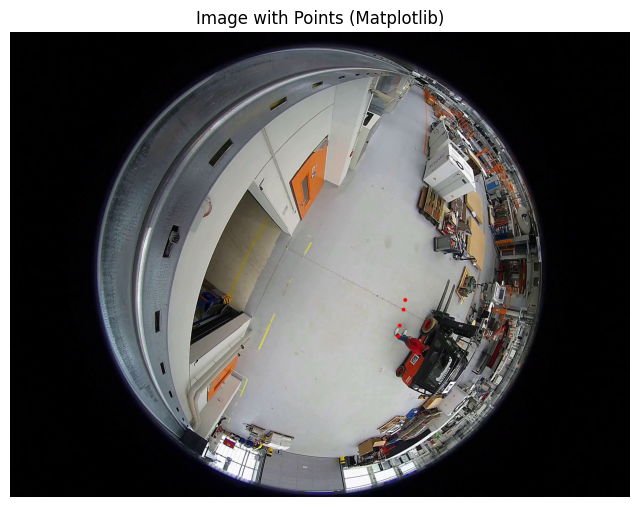

In [ ]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread("first_frame.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

points = [
    (0,1622, 1272),
    (0,1629, 1227),
    (0,1645, 1160),
    (0,1652, 1120)
]


for p in points:
    u, v = int(p[1]), int(p[2])
    cv2.circle(img, (u, v), 8, (255, 0, 0), -1)  

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("Image with Points (Matplotlib)")
plt.axis("off")
plt.show()





False